<a href="https://colab.research.google.com/github/moarshy/PyTorch_fastai_Projects/blob/main/fastai_imgc_plantpathology_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The idea of this notebook is to practice fastai especially chapter 7 of fastbook.

Some of the techniques we will explore includes
1. transfer learning
2. normalising
3. label smoothing
4. mixup
5. test time augmentation

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!pip uninstall fastai -q -y
!pip install fastai -q

In [13]:
import fastai
from fastai.vision.all import *
from sklearn.metrics import roc_auc_score

import pandas as pd
from tqdm.notebook import tqdm

# Load and explore data

In [14]:
PATH = Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology')
DATA_DIR = Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data')
IMG_DIR = PATH/'data/images'
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
SS_CSV = 'sample_submission.csv'

In [15]:
# setting the seeds so experiments are reproducible. With fastai, seeting seed is as simple as this
SEED = 42
set_seed(42)

In [16]:
train_df = pd.read_csv(DATA_DIR/TRAIN_CSV)

In [17]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


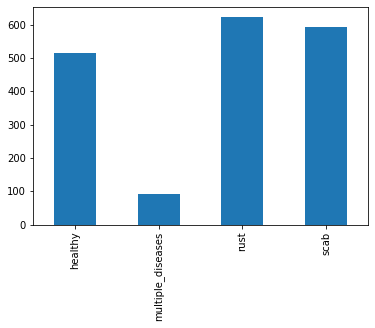

In [18]:
#lets look at the label counts
#lowest count is multiple_disease --> maybe oversampling can be used to increase the number of multiple_disease training example during training
LABELS = ['healthy', 'multiple_diseases', 'rust', 'scab']
train_df[LABELS].sum().plot(kind='bar')

In [19]:
train_df['label'] = train_df[LABELS].idxmax(1)

In [21]:
IMG_SIZE = 128
db = DataBlock(
            blocks=(ImageBlock, CategoryBlock()), 
            getters=[ColReader('image_id', pref=IMG_DIR, suff='.jpg'), ColReader('label')], 
            splitter=RandomSplitter(valid_pct=0.25, seed=SEED),
            item_tfms=Resize(IMG_SIZE),
            batch_tfms=[*aug_transforms(size=IMG_SIZE, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True), 
                        Normalize.from_stats(*imagenet_stats)]
             )

In [22]:
dls = db.dataloaders(source=train_df, bs=64)

In [27]:
# Normalising the images with imagenet stats
# although the std is close 1, mean is not so close 0 

In [25]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.3842,  0.2260, -0.4498], device='cuda:0'),
 TensorImage([0.8355, 0.7763, 0.7996], device='cuda:0'))

Finding baseline and understanding how the different techniques affect training

Things we would like to understand
1.	Mixup
2.	Label smoothing
3.	Tta
4.	Progressive resizing
5.	Different architechture


# Experiment 1.1

* Validation_set = 25%
* Image_size = 128
* Batch_size = 64
* Architecture = resnet18
* Normalize = imagenet
* Transfer learning = yes
* LR steepest from lr_find
* Fine_tune [freeze epochs =2, unfreeze 4]
* Fp16


In [ ]:
IMG_SIZE = 128
BS = 64

In [28]:
opt_func = partial(Adam, lr=1E-3, wd=0.01, eps=1e-8)
learn = cnn_learner(dls, resnet18, opt_func=opt_func, metrics=accuracy).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.019054606556892395)

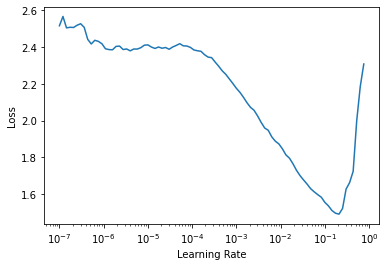

In [29]:
learn.lr_find()

In [30]:
learn.fine_tune(4, base_lr=0.00174, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,2.021911,1.199653,0.606593,02:26
1,1.513693,0.923125,0.716484,01:09


epoch,train_loss,valid_loss,accuracy,time
0,0.857292,0.903573,0.740659,01:09
1,0.792759,0.798702,0.789011,01:10
2,0.705859,0.784783,0.797802,01:09
3,0.621919,0.752377,0.806593,01:10


In [ ]:
learn.save(f'{DATA_DIR}/model/simp/model_e1.1')

Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data/model/simp/model_e1.1.pth')

In [ ]:
classi = ClassificationInterpretation.from_learner(learn)

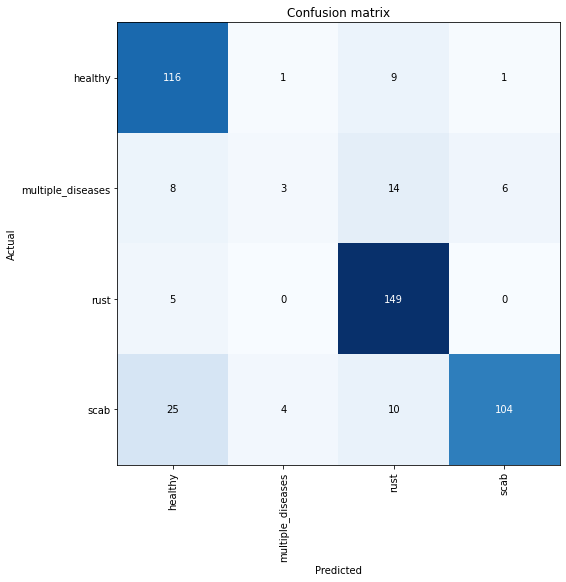

In [ ]:
classi.plot_confusion_matrix(figsize=(12,8))

In [ ]:
classi.most_confused()

[('scab', 'healthy', 25),
 ('multiple_diseases', 'rust', 14),
 ('scab', 'rust', 10),
 ('healthy', 'rust', 9),
 ('multiple_diseases', 'healthy', 8),
 ('multiple_diseases', 'scab', 6),
 ('rust', 'healthy', 5),
 ('scab', 'multiple_diseases', 4),
 ('healthy', 'multiple_diseases', 1),
 ('healthy', 'scab', 1)]

# Experiment 1.2

* Validation_set = 25%
* Image_size = 128
* Batch_size = 64
* Architecture = resnet18
* Normalize = imagenet
* Transfer learning = yes
* LR steepest from lr_find
* Fine_tune [freeze epochs =2, unfreeze 4]
* Fp16
* mixup

In [ ]:
opt_func = partial(Adam, lr=1E-3, wd=0.01, eps=1e-8)
learn = cnn_learner(dls, resnet18, opt_func=opt_func, metrics=accuracy, cbs=MixUp()).to_fp16()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.033113110810518265)

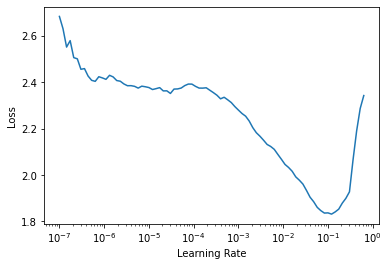

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, base_lr=0.033, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,1.750810,1.843139,0.624176,01:07
1,1.588443,1.285825,0.681319,01:07


epoch,train_loss,valid_loss,accuracy,time
0,1.107040,6.791748,0.386813,01:08
1,0.940501,2.882418,0.714286,01:08
2,0.863911,0.611626,0.837363,01:08
3,0.796120,0.524601,0.843956,01:08


In [ ]:
# few interesting things to note
# valid_loss < train_loss (not same as exp 1.1)
# better accuracy
# as mentioned in fastbook with mix_up we need to train longer

In [ ]:
learn.save(f'{DATA_DIR}/model/simp/model_e1.2')

Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data/model/simp/model_e1.2.pth')

In [ ]:
classi2 = ClassificationInterpretation.from_learner(learn)

# Experiment 1.3

* Validation_set = 25%
* Image_size = 128
* Batch_size = 64
* Architecture = resnet18
* Normalize = imagenet
* Transfer learning = yes
* LR steepest from lr_find
* Fine_tune [freeze epochs =2, unfreeze 4]
* Fp16
* label_smoothing


In [ ]:
opt_func = partial(Adam, lr=1E-3, wd=0.01, eps=1e-8)
learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), opt_func=opt_func, metrics=accuracy).to_fp16()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.001737800776027143)

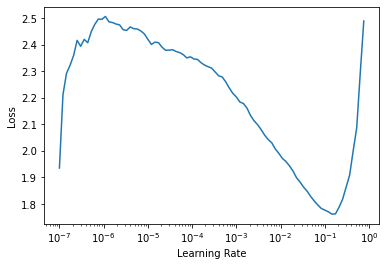

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, base_lr=0.00174, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,2.026796,1.157027,0.604396,01:08
1,1.666298,1.234695,0.692308,01:08


epoch,train_loss,valid_loss,accuracy,time
0,1.257542,1.160515,0.758242,01:09
1,1.156873,1.059816,0.769231,01:09
2,1.068004,0.951512,0.808791,01:09
3,1.003853,0.931812,0.815385,01:09


In [ ]:
# training_loss much higher than exp1.1
# valid_loss < training_loss
# accuracy around exp1.1
# exp 1.3 better than exp 1.1 trianing_loss still high compared to exp1.1 but accuracy similar; 
# valid_loss still lower compared to train_loss hence able to train longer ---> not possible for exp1.1

In [ ]:
learn.save(f'{DATA_DIR}/model/simp/model_e1.3')

Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data/model/simp/model_e1.3.pth')

In [ ]:
classi3 = ClassificationInterpretation.from_learner(learn)

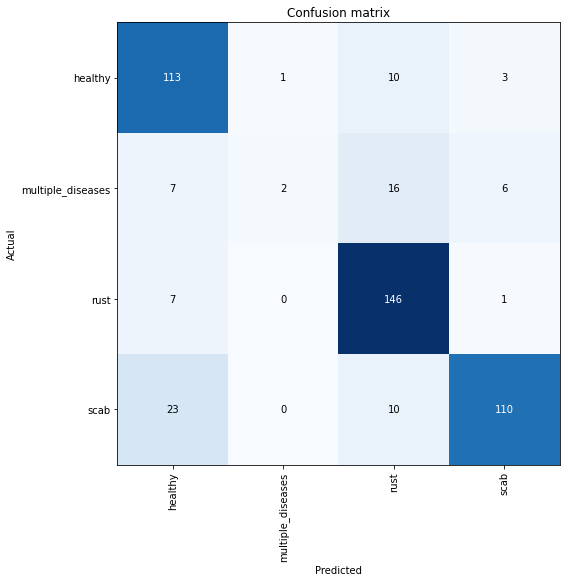

In [ ]:
classi3.plot_confusion_matrix(figsize=(12,8))

In [ ]:
classi3.most_confused()

[('scab', 'healthy', 23),
 ('multiple_diseases', 'rust', 16),
 ('healthy', 'rust', 10),
 ('scab', 'rust', 10),
 ('multiple_diseases', 'healthy', 7),
 ('rust', 'healthy', 7),
 ('multiple_diseases', 'scab', 6),
 ('healthy', 'scab', 3),
 ('healthy', 'multiple_diseases', 1),
 ('rust', 'scab', 1)]

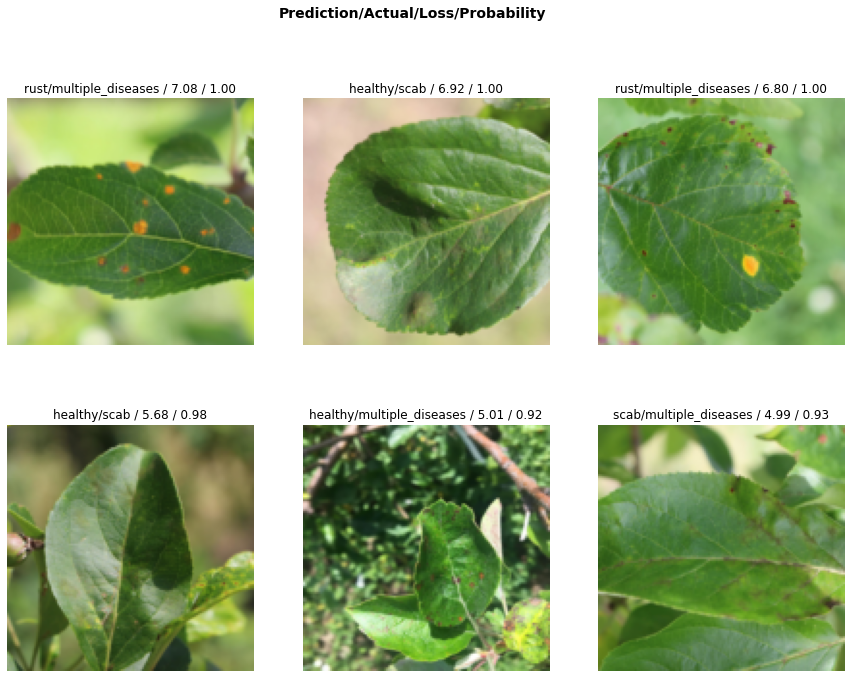

In [ ]:
classi3.plot_top_losses(6, figsize=(15,11))

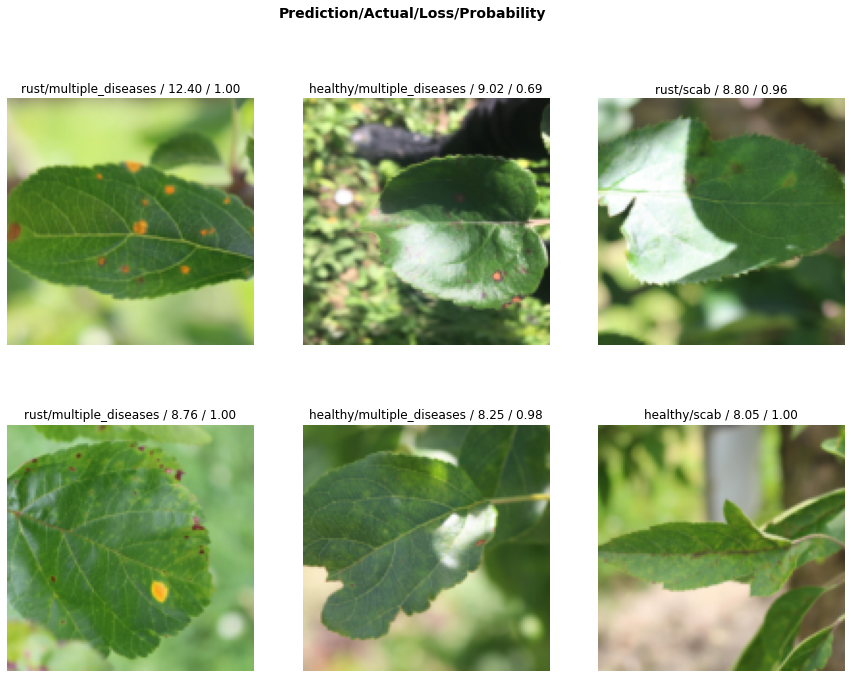

In [ ]:
classi.plot_top_losses(6, figsize=(15,11))

In [ ]:
# lower top losses with exp1.3

# Experiment 1.4

* Validation_set = 25%
* Image_size = 128
* Batch_size = 64
* Architecture = resnet18
* Normalize = imagenet
* Transfer learning = yes
* LR steepest from lr_find
* Fine_tune [freeze epochs =2, unfreeze 4]
* Fp16
* label_smoothing, mixup

In [ ]:
opt_func = partial(Adam, lr=1E-3, wd=0.01, eps=1e-8)
learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=opt_func, metrics=accuracy,
                    cbs=MixUp()).to_fp16()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=7.585775847473997e-07)

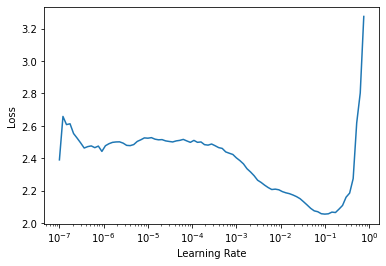

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, 5e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,2.008584,1.272415,0.676923,01:12
1,1.800105,1.417273,0.663736,01:12


epoch,train_loss,valid_loss,accuracy,time
0,1.398447,1.043831,0.718681,01:11
1,1.242266,0.849145,0.778022,01:12
2,1.127304,0.807087,0.826374,01:10
3,1.050217,0.770368,0.837363,01:10


In [ ]:
# very similar to exp1.2

In [ ]:
learn.save(f'{DATA_DIR}/model/simp/model_e1.4')

Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data/model/simp/model_e1.4.pth')

In [ ]:
classi4 = ClassificationInterpretation.from_learner(learn)

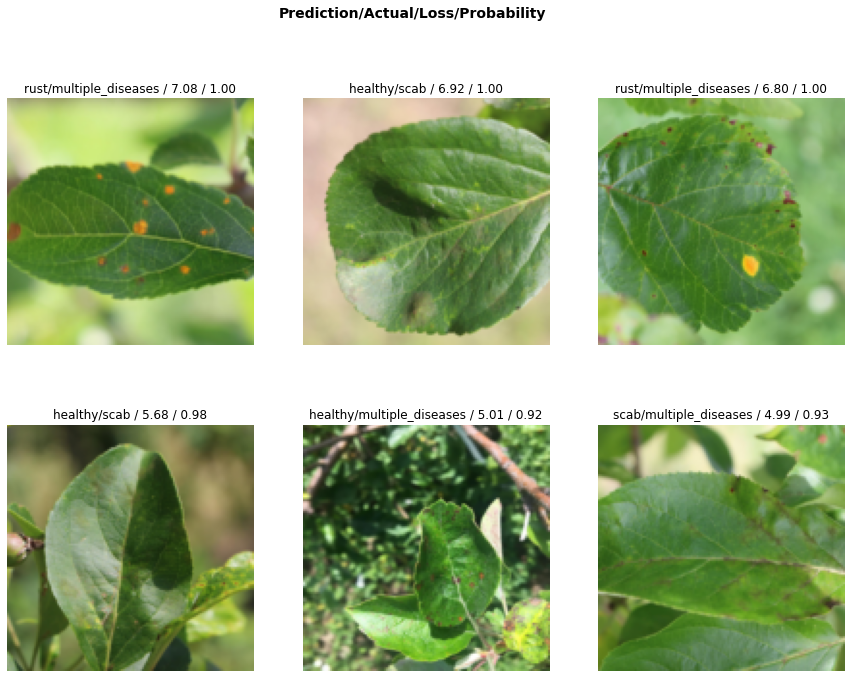

In [ ]:
classi3.plot_top_losses(6, figsize=(15,11))

# Experiment 1.5 -- progressive resizing

* Validation_set = 25%
* Image_size = [128, 256, 512]
* Batch_size = [64, 32, 16]
* Architecture = resnet18
* Normalize = imagenet
* Transfer learning = No
* LR steepest from lr_find
* Fine_tune [freeze epochs =2, unfreeze 4]
* Fp16
* mixup

In [ ]:
dls = db.dataloaders(source=train_df, bs=64)

In [ ]:
opt_func = partial(Adam, lr=1E-3, wd=0.01, eps=1e-8)
learn = cnn_learner(dls, xresnet18, loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=opt_func, metrics=accuracy,
                    cbs=MixUp()).to_fp16()

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=6.309573450380412e-07)

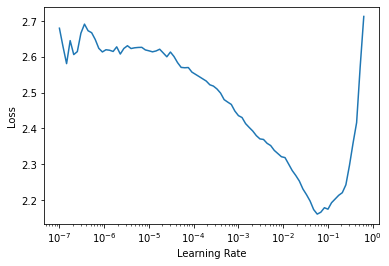

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.141562,3.788523,0.435165,01:08
1,1.823819,1.419572,0.542857,01:08
2,1.595237,2.199033,0.232967,01:08
3,1.463802,2.185357,0.382418,01:08
4,1.358717,1.394614,0.512088,01:08


In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.171724,1.617884,0.553846,01:08
1,1.193308,1.575951,0.465934,01:08
2,1.192400,1.562823,0.505495,01:08
3,1.170577,1.158422,0.613187,01:08
4,1.140611,1.067181,0.646154,01:08


In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.068441,1.408504,0.600000,01:08
1,1.139749,1.460441,0.586813,01:08
2,1.156068,2.075771,0.494505,01:08
3,1.138902,1.550369,0.617582,01:08
4,1.098805,1.183306,0.652747,01:08


In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.036539,0.959289,0.701099,01:08
1,1.070923,2.104403,0.465934,01:08
2,1.107815,1.184471,0.654945,01:08
3,1.063828,1.412535,0.650549,01:09
4,1.023211,0.986974,0.740659,01:10


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=1.5848931980144698e-06)

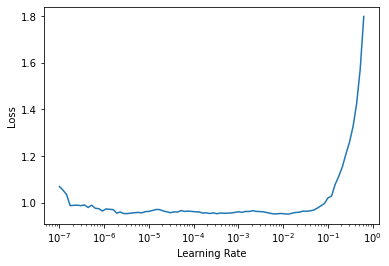

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.959256,0.970581,0.731868,01:11
1,0.969081,0.987849,0.729670,01:09
2,0.961336,0.998659,0.727473,01:08
3,0.968320,1.008746,0.718681,01:08
4,0.971529,1.036341,0.716484,01:08


In [ ]:
# sort of reaching a plateau

In [ ]:
learn.save(f'{DATA_DIR}/model/simp/model_exp1.5_128')

Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data/model/simp/model_exp1.5_128.pth')

In [ ]:
IMG_SIZE = 256
BS = 32
learn.dls = db.dataloaders(source=train_df, bs=BS)

In [ ]:
learn.dls.bs

32

In [ ]:
learn.fine_tune(3, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.988300,0.951943,0.749451,01:09


epoch,train_loss,valid_loss,accuracy,time
0,0.995177,0.954933,0.734066,01:09
1,0.972363,0.908186,0.749451,01:11
2,0.977432,0.991663,0.731868,01:11


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.0964781722577754e-06)

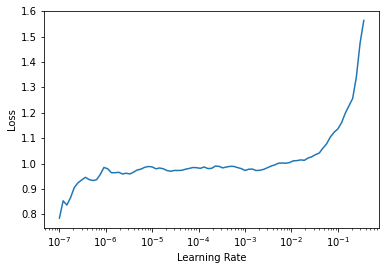

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, 1e-7, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,0.975685,0.938882,0.734066,01:11
1,0.973440,0.916660,0.751648,01:11


epoch,train_loss,valid_loss,accuracy,time
0,0.937444,0.947692,0.738462,01:12
1,0.947823,0.943881,0.747253,01:12
2,0.957365,0.957274,0.740659,01:12
3,0.964721,0.923262,0.738462,01:11


In [ ]:
learn.save(f'{DATA_DIR}/model/simp/model_exp1.5_256')

Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data/model/simp/model_exp1.5_256.pth')

# Experiment 1.6 - transfer learning + progressive resizing

* Validation_set = 25%
* Image_size = 128
* Batch_size = 64
* Architecture = resnet18
* Normalize = imagenet
* Transfer learning = yes
* LR steepest from lr_find
* Fine_tune [freeze epochs =2, unfreeze 4]
* Fp16
* label_smoothing, mixup

In [ ]:
IMG_SIZE = 128
BS=64
dls = db.dataloaders(source=train_df, bs=64)

In [ ]:
opt_func = partial(Adam, lr=1E-3, wd=0.01, eps=1e-8)
learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=opt_func, metrics=accuracy,
                    cbs=MixUp()).to_fp16()

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.009120108559727669)

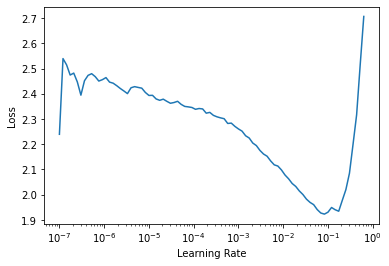

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(6, base_lr=0.009, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,1.901228,1.379864,0.685714,01:08
1,1.724523,1.223089,0.694506,01:08
2,1.519233,0.970507,0.734066,01:08


epoch,train_loss,valid_loss,accuracy,time
0,1.050608,0.820809,0.821978,01:09
1,1.000784,0.901385,0.775824,01:09
2,0.947669,0.851698,0.797802,01:10
3,0.908452,0.730876,0.852747,01:10
4,0.863833,0.670278,0.865934,01:11
5,0.832602,0.690928,0.854945,01:11


SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=4.786300905834651e-06)

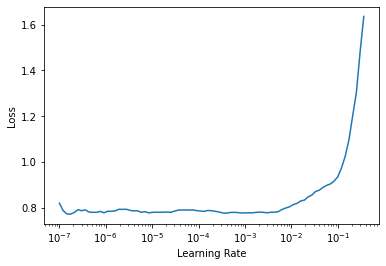

In [ ]:
learn.lr_find()

In [ ]:
# train longer since valid_loss < train_loss

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.799706,0.662830,0.874725,01:10
1,0.779203,0.695137,0.830769,01:11
2,0.783091,0.623650,0.868132,01:11
3,0.767803,0.591153,0.894506,01:10
4,0.763562,0.587561,0.898901,01:10


SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=9.12010818865383e-07)

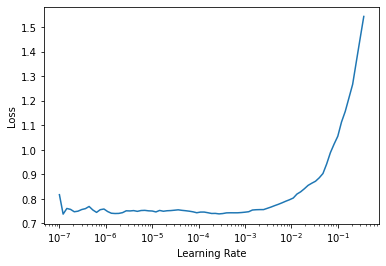

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.737896,0.601451,0.879121,01:11
1,0.734686,0.601011,0.883516,01:11
2,0.737360,0.586183,0.907692,01:11
3,0.732952,0.616111,0.881319,01:11
4,0.733738,0.601167,0.887912,01:12


In [ ]:
learn.save(f'{DATA_DIR}/model/simp/model_exp1.6_128')

Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data/model/simp/model_exp1.6_128.pth')

In [ ]:
# valid_loss is still below valid_loss --> will further trianing be helpful?

In [ ]:
IMG_SIZE = 256
BS=32
learn.dls = db.dataloaders(source=train_df, bs=BS)

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=7.585775847473997e-07)

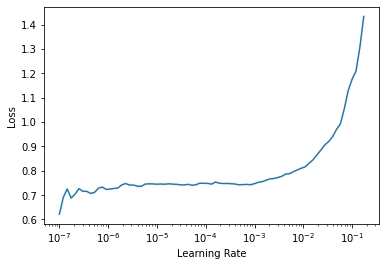

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(5, 1e-4, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,0.745044,0.590691,0.890110,01:12
1,0.738581,0.583384,0.896703,01:12


epoch,train_loss,valid_loss,accuracy,time
0,0.762463,0.596265,0.890110,01:15
1,0.751761,0.594781,0.894506,01:12
2,0.737884,0.582520,0.881319,01:11
3,0.741425,0.583516,0.892308,01:10
4,0.745383,0.593848,0.898901,01:09


In [ ]:
learn.save(f'{DATA_DIR}/model/simp/model_exp1.6_256')

Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data/model/simp/model_exp1.6_256.pth')

In [ ]:
# seem to hv improved only a little if any

# Experiment 1.7 - bigger architecture



In [ ]:
IMG_SIZE = 128
BS = 64
dls = db.dataloaders(source=train_df, bs=BS)

In [ ]:
opt_func = partial(Adam, lr=1E-3, wd=0.01, eps=1e-8)
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=opt_func, metrics=accuracy,
                    cbs=MixUp()).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=1.5848931980144698e-06)

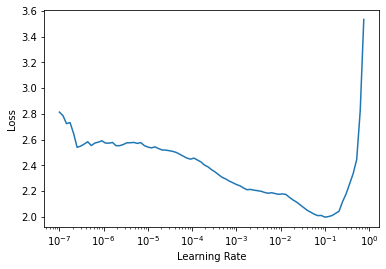

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, base_lr=1e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,2.071204,1.222445,0.716484,01:09
1,1.861563,1.265439,0.723077,01:09


epoch,train_loss,valid_loss,accuracy,time
0,1.541516,1.025851,0.767033,01:09
1,1.499814,1.346275,0.729670,01:09
2,1.416895,0.928945,0.808791,01:10
3,1.361892,0.914955,0.817582,01:10


In [ ]:
learn.fine_tune(4, base_lr=1e-3, freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,time
0,1.263612,1.100601,0.751648,01:09


epoch,train_loss,valid_loss,accuracy,time
0,1.256830,0.989254,0.775824,01:09
1,1.197918,1.210898,0.729670,01:10
2,1.164949,0.936272,0.804396,01:10
3,1.129679,0.873319,0.817582,01:09


SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=1.0964781722577754e-06)

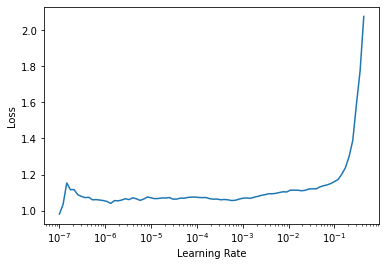

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.039600,0.883810,0.808791,01:09
1,1.037455,0.828964,0.848352,01:09
2,1.049043,0.920815,0.830769,01:10
3,1.022618,0.819875,0.857143,01:10
4,0.992559,0.822160,0.863736,01:09
5,0.986571,0.797719,0.859341,01:10


In [ ]:
# could bigger be trianed longer and get a better results

SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=6.309573450380412e-07)

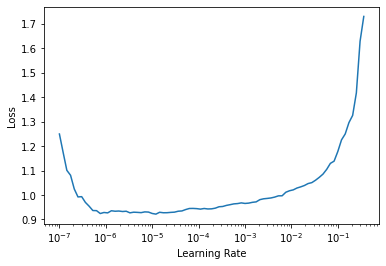

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.948018,0.707271,0.876923,01:09
1,0.935715,0.851733,0.848352,01:09
2,0.935873,0.787820,0.876923,01:10
3,0.930118,0.869056,0.863736,01:09
4,0.922284,0.788341,0.881319,01:09
5,0.911660,0.783954,0.890110,01:10


In [ ]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.881456,0.872817,0.883516,01:10
1,0.890523,0.950059,0.896703,01:10
2,0.880458,0.890253,0.872527,01:11
3,0.890728,0.834483,0.892308,01:11
4,0.885923,0.830668,0.901099,01:10
5,0.868469,0.860374,0.892308,01:11


In [ ]:
# resnet50 didnt improve the accuracy

In [ ]:
#resnext

In [ ]:
from torchvision.models import resnext50_32x4d

In [ ]:
IMG_SIZE = 128
BS = 64
dls = db.dataloaders(source=train_df, bs=BS)

In [ ]:
opt_func = partial(Adam, lr=1E-3, wd=0.01, eps=1e-8)
learn = cnn_learner(dls, resnext50_32x4d, loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=opt_func, metrics=accuracy,
                    cbs=MixUp()).to_fp16()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0008317637839354575)

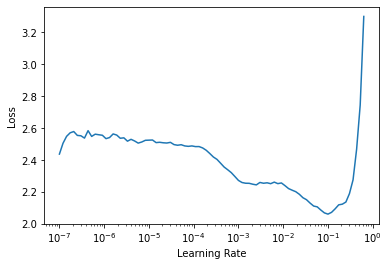

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(5, 0.00083, freeze_epochs=2)

epoch,train_loss,valid_loss,accuracy,time
0,2.177189,1.165720,0.637363,01:10
1,1.914569,1.201738,0.654945,01:10


epoch,train_loss,valid_loss,accuracy,time
0,1.551193,1.100266,0.716484,01:11
1,1.573563,1.126828,0.718681,01:12
2,1.528790,1.066831,0.729670,01:14
3,1.513477,1.041534,0.714286,01:13
4,1.472423,1.026433,0.725275,01:11


SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=1.0964781722577754e-06)

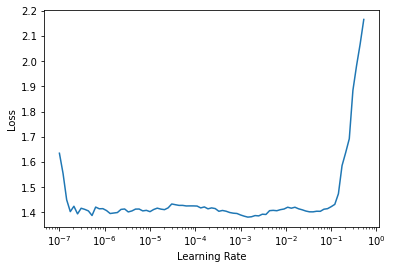

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.383892,2.418365,0.578022,01:11
1,1.318861,3.918447,0.751648,01:11
2,1.159427,1.022840,0.876923,01:11
3,1.065390,1.024951,0.907692,01:11
4,0.994090,0.885035,0.898901,01:11


In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.899530,0.775675,0.905495,01:10
1,0.894972,1.829189,0.909890,01:10
2,0.873662,0.725374,0.909890,01:10
3,0.850628,0.811606,0.920879,01:10
4,0.821917,0.923385,0.918681,01:10


In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.806140,0.937225,0.916484,01:10
1,0.804665,0.645669,0.923077,01:10
2,0.820901,2.087097,0.837363,01:13
3,0.814605,0.998106,0.934066,01:13
4,0.791542,0.887447,0.934066,01:13


In [ ]:
# highest accuracy so far 
# is it overfitting

In [ ]:
learn.save(f'{DATA_DIR}/model/simp/model_resnext')

Path('/content/drive/MyDrive/colab_notebooks/fastai/Plant Pathology/data/model/simp/model_resnext.pth')

In [ ]:
classi = ClassificationInterpretation.from_learner(learn)